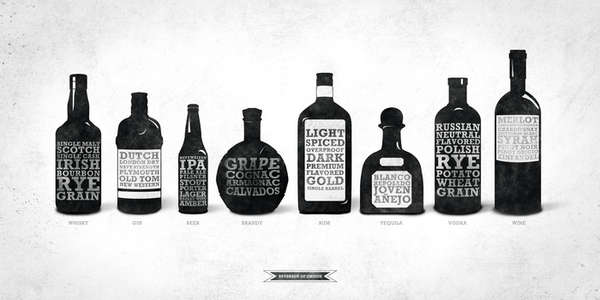

In [1]:
from IPython.display import Image
Image("beverage_of_choice.jpeg")

### Domain and Dataset
We examine liquor sales, for the state of Iowa, for the year 2015. Our data consists of liquor transactions (type of liquor sold, number of bottles, volume in liters and gallons sold, etc.) for each store on a certain day. For each store, we also have that store's county, county number, and the zip code in which that store is situated.

### Problem Statement
Our preliminary goal is to understand the meaningful relationships that exist, if any, between certain features of a store, such as the average price of a bottle sold, and our target, which is total sales in a year. In doing so, we strive to develop a model that can predict what our total sales for a store will be, depending on our features. Our final objective in studying these relationships is to give you a clear recommendation on which areas of Iowa to open your new alcohol establishment.

### Data Preparation

We will begin by loading, cleaning, and  preparing our data for analysis:

In [2]:
# Load modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import pandas as pd

In [3]:
# Load the data into a DataFrame
df = pd.read_csv('Iowa_Liquor_sales_sample_10pct.csv')

# Convert dates to datetime objects
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [4]:
# Get an initial look at our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null datetime64[ns]
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null object
County Number            269878 non-null float64
County                   269878 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null object
State Bottle Retail      270955 non-null object
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null object
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: datetime64

In [5]:
# Remove $ from columns, since those will cause a problem. Also convert these columns to floats
cols = ['State Bottle Cost', 'State Bottle Retail', 'Sale (Dollars)']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x[1:]))

In [6]:
# See how many bad values are in the database
df.isnull().sum()

Date                        0
Store Number                0
City                        0
Zip Code                    0
County Number            1077
County                   1077
Category                   68
Category Name             632
Vendor Number               0
Item Number                 0
Item Description            0
Bottle Volume (ml)          0
State Bottle Cost           0
State Bottle Retail         0
Bottles Sold                0
Sale (Dollars)              0
Volume Sold (Liters)        0
Volume Sold (Gallons)       0
dtype: int64

In [7]:
# Drop bad values. Though we have possibly anywhere from 1,077 to 1,800 transactions that
# will disappear, this is a very small fraction of our total of 270,955 rows. 
df.dropna(inplace=True)

In [8]:
# Change certain float columns to int columns
df['County Number'] = df['County Number'].astype(int)
df['Category'] = df['Category'].astype(int)

In [9]:
# Remove redundant or columns that will not be used
del df['Vendor Number']

In [10]:
# Convert Zip Code column to a category
df['Zip Code'] = df['Zip Code'].astype('category')

In [11]:
# Here, we will create new columns by using the other columns. For example, we will create
# a Price Per Bottle column.

# Create a Margin column
df['Margin'] = (df['State Bottle Retail'] - df['State Bottle Cost']) * df['Bottles Sold']

# Create a Price Per Liter column
df['Price Per Liter'] = df['Sale (Dollars)'] / df['Volume Sold (Liters)']

# Create a Price Per Bottle column
df['Price Per Bottle'] = df['Sale (Dollars)'] / df['Bottles Sold']

In [12]:
# Create an Alcohol Type column. This will help us pare down the wide range of products into
# more meaningful categories (for example, thinking of 'Mr. Boston Apricot Brandy' and Korbel
# Brandy' as both belonging to the category of brandy will be more benefical to our analysis
# than considering each as their own separate category)
def alcohol_type(alcohol):
    alcohol = alcohol.lower()
    if 'liqueur' in alcohol or 'viniq ruby' in alcohol or 'piehole apple' in alcohol:
        return 'liqueur'
    elif 'whisk' in alcohol or 'scotch' in alcohol or 'tin cup' in alcohol \
        or 'jack daniels' in alcohol or 'jameson' in alcohol or 'five star blended' in alcohol\
        or 'seagrams seven crown dark' in alcohol:
        return 'whiskey'
    elif 'margarita' in alcohol or 'hot sex' in alcohol:
        return 'mixers'
    elif 'vodka' in alcohol or '44 north' in alcohol\
    or 'three olives marilyn monroe' in alcohol or 'absolut' in alcohol:
        return 'vodka'
    elif 'gin' in alcohol:
        return 'gin'
    elif 'tequila' in alcohol or 'juarez gold' in alcohol:
        return 'tequila'
    elif 'schnapps' in alcohol or 'dekuyper' in alcohol:
        return 'schnapps'
    elif 'rum' in alcohol:
        return 'rum'
    elif 'brandy' in alcohol or 'brandies' in alcohol:
        return 'brandy'
    elif 'creme' in alcohol:
        return 'creme'
    elif 'beer' in alcohol:
        return 'beer'
    elif 'amaretto' in alcohol:
        return 'amaretto'
    elif 'anisette' in alcohol:
        return 'anisette'
    elif 'jim beam' in alcohol or 'knob creek' in alcohol or 'wild turkey' in alcohol\
    or "maker's mark" in alcohol:
        return 'bourbon'
    elif 'windsor' in alcohol or 'canadian whisky' in alcohol or 'canadian whiskey' in alcohol\
    or 'black velvet' in alcohol:
        return 'canadian whiskey'
    else:
        return 'misc'

df['Alcohol Type'] = df['Item Description'].apply(alcohol_type)

In [13]:
# Create quarter column denoting which quarter of the year
def quarter(date):
    if (date.month >= 1) & (date.month <= 3):
        return "Q1"
    elif (date.month >= 4) & (date.month <= 6):
        return "Q2"
    elif (date.month >= 7) & (date.month <= 9):
        return "Q3"
    else:
        return "Q4"
df['Quarter'] = df['Date'].apply(quarter)
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Item Number,Item Description,...,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Margin,Price Per Liter,Price Per Bottle,Alcohol Type,Quarter
0,2015-11-04,3717,SUMNER,50674,9,Bremer,1051100,APRICOT BRANDIES,54436,Mr. Boston Apricot Brandy,...,6.75,12,81.00,9.0,2.38,27.00,9.000000,6.75,brandy,Q4
1,2016-03-02,2614,DAVENPORT,52807,82,Scott,1011100,BLENDED WHISKIES,27605,Tin Cup,...,20.63,2,41.26,1.5,0.40,13.76,27.506667,20.63,whiskey,Q1
2,2016-02-11,2106,CEDAR FALLS,50613,7,Black Hawk,1011200,STRAIGHT BOURBON WHISKIES,19067,Jim Beam,...,18.89,24,453.36,24.0,6.34,151.20,18.890000,18.89,bourbon,Q1
3,2016-02-03,2501,AMES,50010,85,Story,1071100,AMERICAN COCKTAILS,59154,1800 Ultimate Margarita,...,14.25,6,85.50,10.5,2.77,28.50,8.142857,14.25,mixers,Q1
4,2015-08-18,3654,BELMOND,50421,99,Wright,1031080,VODKA 80 PROOF,35918,Five O'clock Vodka,...,10.80,12,129.60,21.0,5.55,43.20,6.171429,10.80,vodka,Q3


In [14]:
# Here, we will determine which stores were open all of 2015

dates = df.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]

# To handle outliers, which are stores that opened or closed throughout 2015, we will
# filter out stores that opened or closed throughout fiscal year 2015 (March to October 2015)
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")

mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)

good_stores = dates[mask]["Store Number"]

df = df[df['Store Number'].isin(good_stores)]

In [15]:
# Sales per store, 2015

# Filter by our start and end dates
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales = df[mask]

# Group by store name and compute aggregate sum and mean functions
sales = sales.groupby(by=["Store Number"], as_index=False)
sales = sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.sum,
                   "Price Per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0],
                   "Price Per Bottle" : np.mean})

# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]

# And then rename the columns
sales.rename(columns={'City <lambda>' : 'City',
                      'Sale (Dollars) sum' : 'Sale (Dollars), Total',
                      'Sale (Dollars) mean' : 'Sale (Dollars), Average',
                      'County Number <lambda>' : 'County Number',
                      'Price Per Liter mean' : 'Price Per Liter, Average',
                      'Zip Code <lambda>' : 'Zip Code',
                      'Volume Sold (Liters) sum' : 'Volume Sold (Liters), Total',
                      'Volume Sold (Liters) mean' : 'Volume Sold (Liters), Average',
                      'Margin sum' : 'Margin, Total',
                      'Price Per Bottle mean' : 'Price Per Bottle, Average'
                     }, inplace=True)
sales.head()

,Store Number,City,County Number,"Price Per Bottle, Average","Sale (Dollars), Total","Sale (Dollars), Average","Volume Sold (Liters), Total","Volume Sold (Liters), Average",Zip Code,"Price Per Liter, Average","Margin, Total"
0,2106,CEDAR FALLS,7,15.459734,146038.70,277.640114,9719.85,18.478802,50613,17.844997,48742.20
1,2113,GOWRIE,94,16.315646,9310.22,63.334830,659.85,4.488776,50543,18.507700,3109.04
2,2130,WATERLOO,7,14.740767,111583.91,285.380844,6879.37,17.594297,50703,16.817589,37229.32
3,2152,ROCKWELL,17,12.887660,7721.08,54.759433,633.37,4.491986,50469,13.020765,2587.53
4,2178,WAUKON,3,14.558692,24324.18,102.633671,1917.12,8.089114,52172,16.053844,8165.70


### Top 10 performing zip codes in Iowa

Now that we have filtered out stores that opened or closed in 2015 (handling outliers to an extent), and further refined our look into the remaining stores by looking at just their 2015 data, we are ready to group these stores by zip code. Let us look at the 10 best performing areas in Iowa, by zip code:

In [16]:
# Group alcohol sales by zip code, in descending order of total sales. This will give us 
# the best performing zip codes, in terms of total sales
zip_code_sales = sales.groupby(by=['Zip Code'], as_index=False)
zip_code_sales = zip_code_sales.agg({"Sale (Dollars), Total": np.sum,
                   "Sale (Dollars), Average": np.mean,
                   "Volume Sold (Liters), Total": np.sum,
                   "Volume Sold (Liters), Average": np.mean,
                   "Margin, Total": np.sum,
                   "Price Per Liter, Average": np.mean,
                   "Price Per Bottle, Average" : np.mean})
zip_code_sales.sort_values(ascending=False, by='Sale (Dollars), Total').head(10)

,Zip Code,"Volume Sold (Liters), Total","Sale (Dollars), Total","Volume Sold (Liters), Average","Sale (Dollars), Average","Price Per Liter, Average","Margin, Total","Price Per Bottle, Average"
86,50320,66367.76,1068200.95,11.137151,162.223554,18.890828,356316.11,14.987421
82,50314,58853.62,1038267.17,12.484526,291.983194,27.203608,346409.55,19.909894
326,52402,68951.54,959470.60,9.643974,135.104232,18.328176,320775.79,13.524006
297,52240,55230.10,873107.23,8.297625,128.413474,19.002688,291639.57,14.486304
4,50010,52302.32,767805.14,10.385253,143.129883,17.778504,256762.94,14.516940
373,52807,39654.35,596547.82,13.664293,207.861734,18.754750,199253.77,14.785964
79,50311,41235.28,586225.94,19.124678,269.003250,17.964099,195853.33,15.247180
352,52722,33848.33,557785.69,8.940903,133.225362,17.773006,186241.76,14.924543
74,50266,31448.31,544870.01,14.839409,257.117152,18.880764,182445.87,15.487492
238,51501,35824.44,543081.75,9.674970,141.275695,17.230999,181380.76,12.447553


### Top 10 types of alcohol

We can also look at what types of alcohol are selling the best:

In [17]:
# Group sales by alcohol type, in descending order. This gives us a look at the top alcohol
# types sold, by total sale dollars. Since we are interested in what kinds of alcohol sold
# well in Iowa, regardless of when the store opened or closed in 2015, we will use our
# original, unmasked dataframe
df_sales_by_alcohol = df.groupby(by=['Alcohol Type']).agg(
                  {"Sale (Dollars)": np.sum,
                   "Volume Sold (Liters)": np.sum,
                   "Margin": np.sum,
                   "Price Per Liter": np.mean,
                   "Price Per Bottle" : np.mean}).round(2)
df_sales_by_alcohol.sort_values(ascending=False, by=['Sale (Dollars)']).head(10)

,Price Per Liter,Margin,Sale (Dollars),Volume Sold (Liters),Price Per Bottle
Alcohol Type,,,,,
misc,23.23,2544066.58,7617260.97,403421.17,17.14
vodka,13.40,2370038.84,7091997.28,656486.30,11.90
whiskey,20.66,1902687.73,5697644.02,315063.00,18.72
rum,14.91,1164212.47,3488559.53,255000.84,13.28
canadian whiskey,11.07,676522.61,1991062.51,209192.05,10.37
gin,16.43,522825.28,1566140.89,99362.51,14.43
tequila,30.15,462309.86,1386721.73,77250.22,20.58
liqueur,22.32,460957.29,1380018.29,63767.03,16.75
bourbon,24.29,360692.53,1078058.60,47587.37,18.43


### Top 10 performing cities by zip code

Here, we take a look at the best performing cities. Within those cities, we look at how each zip code perform, again in terms of our target, which is total sales:

In [18]:
# Group our data by city and zip code. We will obtain a table of our top 10 performing cities,
# in terms of total sales, for the year 2015
zip_code_and_city_sales = sales.groupby(by=['City','Zip Code'])
zip_code_and_city_sales = zip_code_and_city_sales.agg({"Sale (Dollars), Total": np.sum,
                   "Sale (Dollars), Average": np.mean,
                   "Volume Sold (Liters), Total": np.sum,
                   "Volume Sold (Liters), Average": np.mean,
                   "Margin, Total": np.sum,
                   "Price Per Liter, Average": np.mean,
                   "Price Per Bottle, Average" : np.mean})
zip_code_and_city_sales.sort_values(ascending=False, by='Sale (Dollars), Total').head(11)

Volume Sold (Liters), Total  Sale (Dollars), Total  \
City            Zip Code                                                       
DES MOINES      50320                        66367.76             1068200.95   
                50314                        58853.62             1038267.17   
CEDAR RAPIDS    52402                        68951.54              959470.60   
IOWA CITY       52240                        55230.10              873107.23   
AMES            50010                        52302.32              767805.14   
DAVENPORT       52807                        39654.35              596547.82   
BETTENDORF      52722                        33848.33              557785.69   
COUNCIL BLUFFS  51501                        35824.44              543081.75   
WEST DES MOINES 50266                        31252.45              541901.76   
CORALVILLE      52241                        29669.21              516438.37   
CEDAR FALLS     50613                        36382.83              515851.85   

                          Volume Sold (Liters), Average  \
City            Zip Code                                  
DES MOINES      50320                         11.137151   
                50314                         12.484526   
CEDAR RAPIDS    52402                          9.643974   
IOWA CITY       52240                          8.297625   
AMES            50010                         10.385253   
DAVENPORT       52807                         13.664293   
BETTENDORF      52722                          8.940903   
COUNCIL BLUFFS  51501                          9.674970   
WEST DES MOINES 50266                         15.540649   
CORALVILLE      52241                         17.733136   
CEDAR FALLS     50613                         10.344526   

                          Sale (Dollars), Average  Price Per Liter, Average  \
City            Zip Code                                                      
DES MOINES      50320                  162.223554                 18.890828   
                50314                  291.983194                 27.203608   
CEDAR RAPIDS    52402                  135.104232                 18.328176   
IOWA CITY       52240                  128.413474                 19.002688   
AMES            50010                  143.129883                 17.778504   
DAVENPORT       52807                  207.861734                 18.754750   
BETTENDORF      52722                  133.225362                 17.773006   
COUNCIL BLUFFS  51501                  141.275695                 17.230999   
WEST DES MOINES 50266                  270.046307                 19.051361   
CORALVILLE      52241                  341.472856                 20.653580   
CEDAR FALLS     50613                  135.804986                 16.576968   

                          Margin, Total  Price Per Bottle, Average  
City            Zip Code                                            
DES MOINES      50320         356316.11                  14.987421  
                50314         346409.55                  19.909894  
CEDAR RAPIDS    52402         320775.79                  13.524006  
IOWA CITY       52240         291639.57                  14.486304  
AMES            50010         256762.94                  14.516940  
DAVENPORT       52807         199253.77                  14.785964  
BETTENDORF      52722         186241.76                  14.924543  
COUNCIL BLUFFS  51501         181380.76                  12.447553  
WEST DES MOINES 50266         181449.95                  15.675427  
CORALVILLE      52241         172420.26                  17.827809  
CEDAR FALLS     50613         172554.57                  14.096864

### Exploratory Data, Visual

We have seen many tables. Now, we will get a visual look at our data of interest.

But first:

In [19]:
# we run a correlation matrix just to get some initial insights on potential
# relationships between our numeric variables
zip_code_sales.corr()

,"Volume Sold (Liters), Total","Sale (Dollars), Total","Volume Sold (Liters), Average","Sale (Dollars), Average","Price Per Liter, Average","Margin, Total","Price Per Bottle, Average"
"Volume Sold (Liters), Total",1.000000,0.994525,0.231447,0.343068,0.319463,0.994637,0.175401
"Sale (Dollars), Total",0.994525,1.000000,0.221000,0.354452,0.346390,0.999998,0.186457
"Volume Sold (Liters), Average",0.231447,0.221000,1.000000,0.846544,-0.110028,0.221355,0.031538
"Sale (Dollars), Average",0.343068,0.354452,0.846544,1.000000,0.266197,0.354580,0.261083
"Price Per Liter, Average",0.319463,0.346390,-0.110028,0.266197,1.000000,0.346190,0.487769
"Margin, Total",0.994637,0.999998,0.221355,0.354580,0.346190,1.000000,0.186435
"Price Per Bottle, Average",0.175401,0.186457,0.031538,0.261083,0.487769,0.186435,1.000000


Now, a visual overview of relationships between our numeric variables:

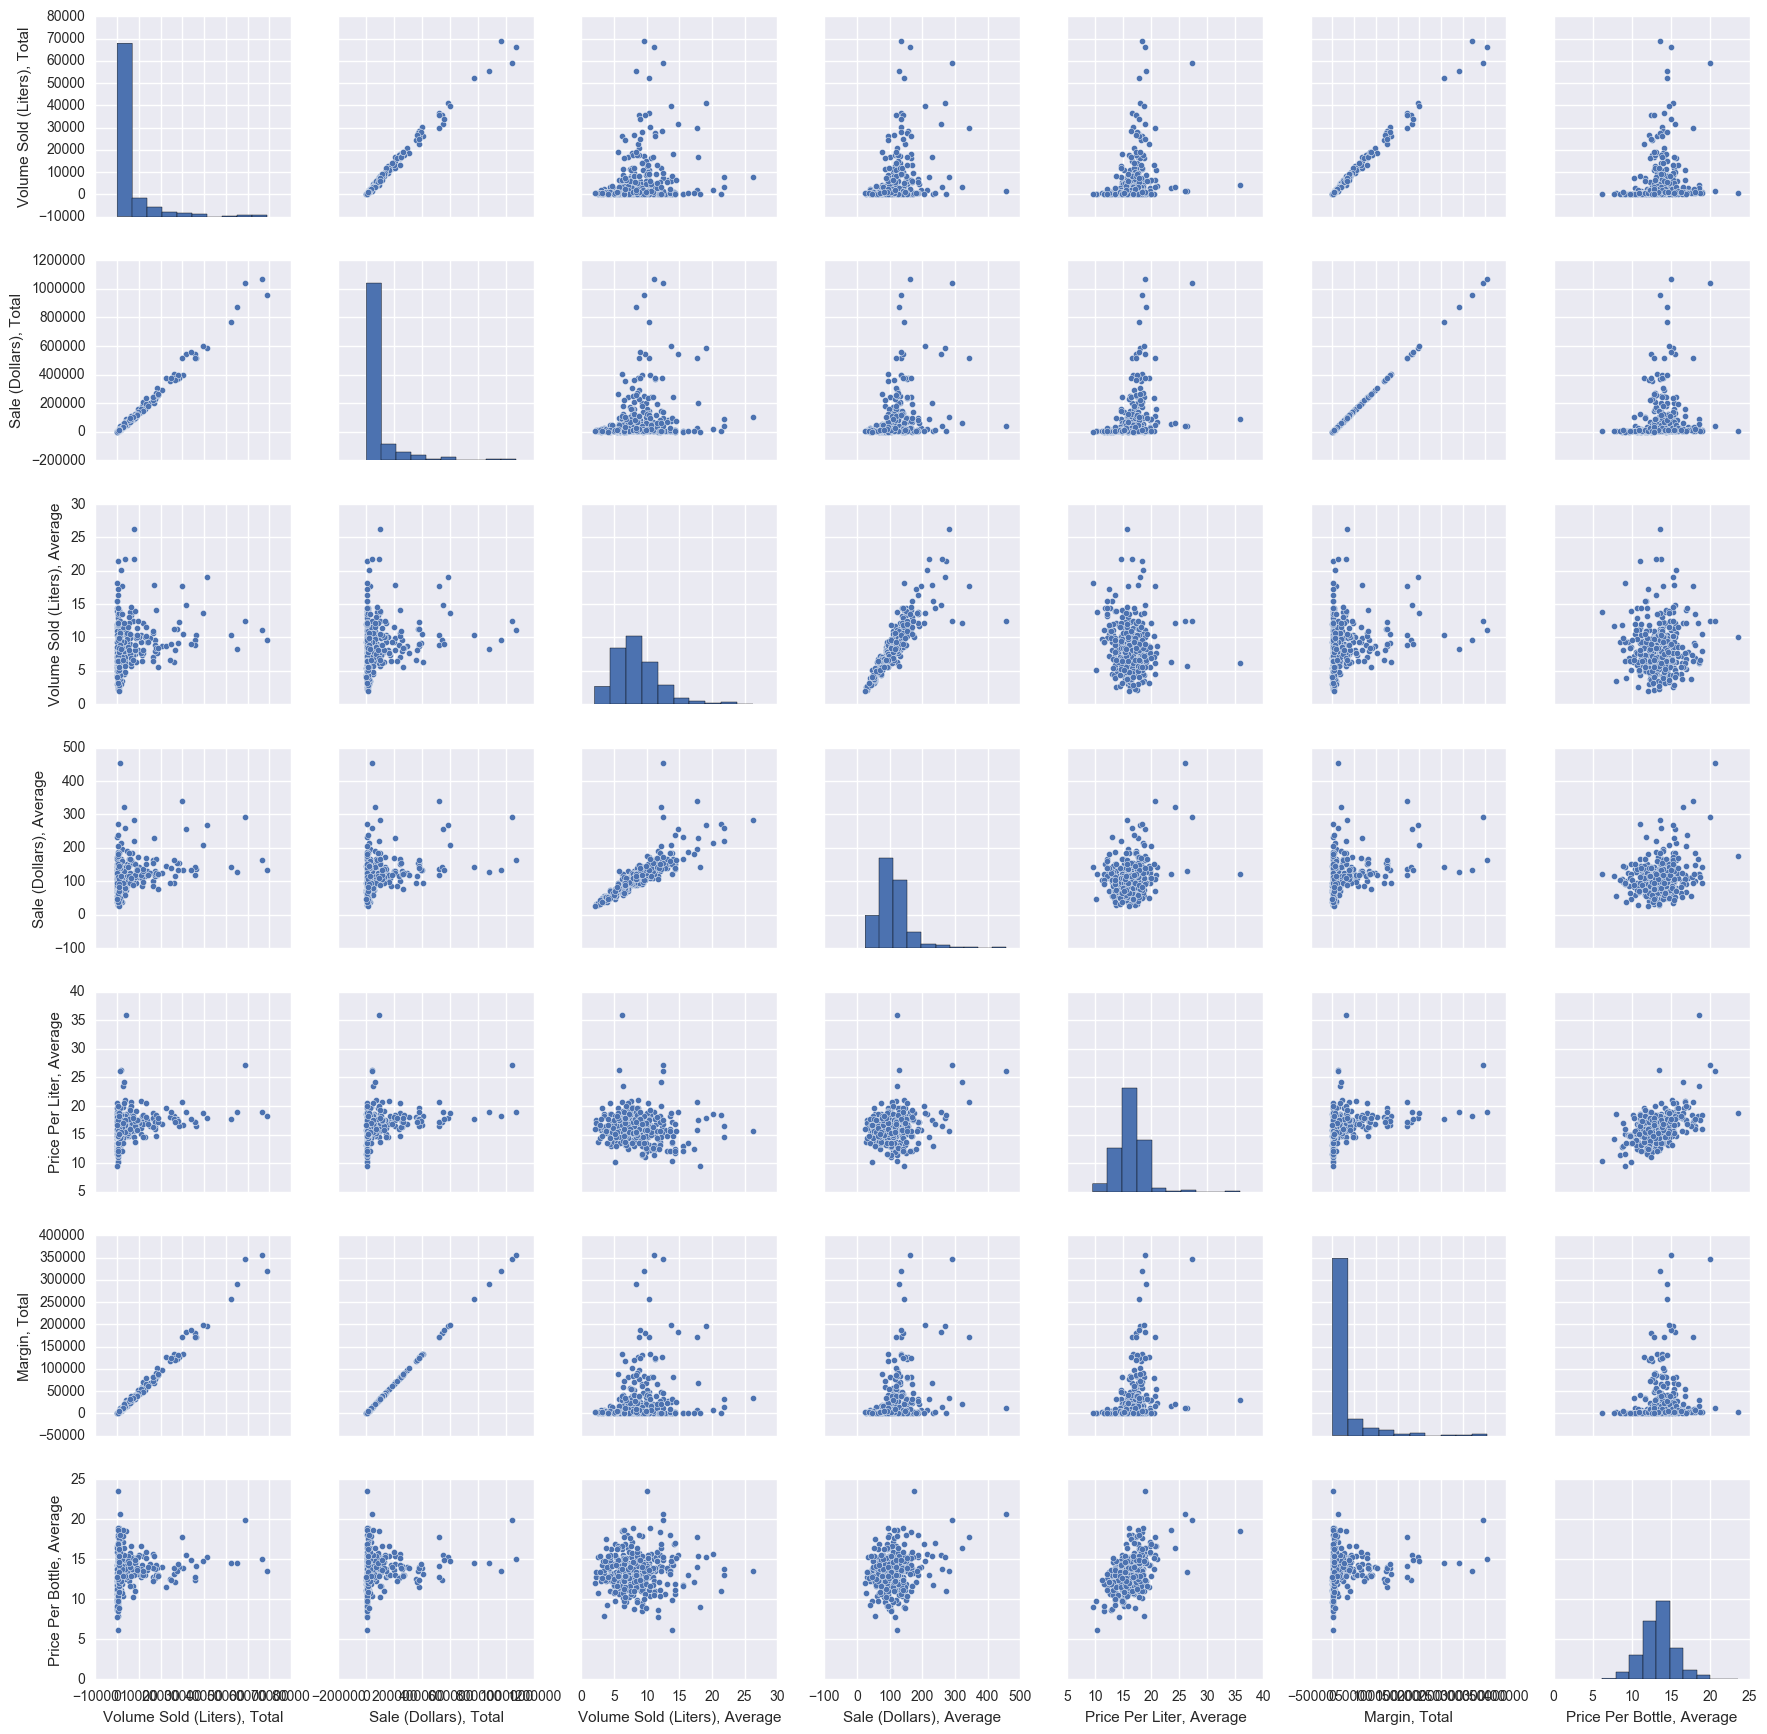

In [20]:
sns.pairplot(data=zip_code_sales)

A visual chart of our best selling alcohols by type (i.e. Whiskey, Vodka, Gin):

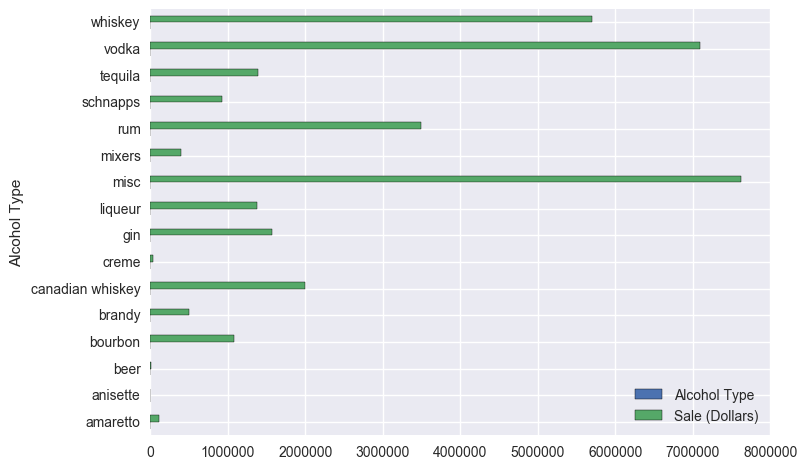

In [21]:
# horizontal bar plot
df_sales_by_alcohol_refined = pd.DataFrame(data=df_sales_by_alcohol, columns=['Alcohol Type','Sale (Dollars)'])
df_sales_by_alcohol_refined.plot.barh()

Let us look at how our total sales values are distributed throughout the state of Iowa:

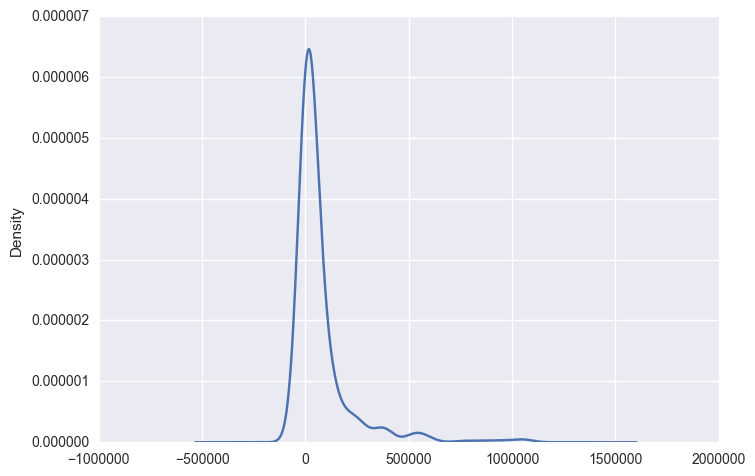

In [22]:
# density estimation plot
zip_code_sales['Sale (Dollars), Total'].plot.kde()

Here is a scatter matrix to see what kind of relationship the average price per bottle has to total sales:

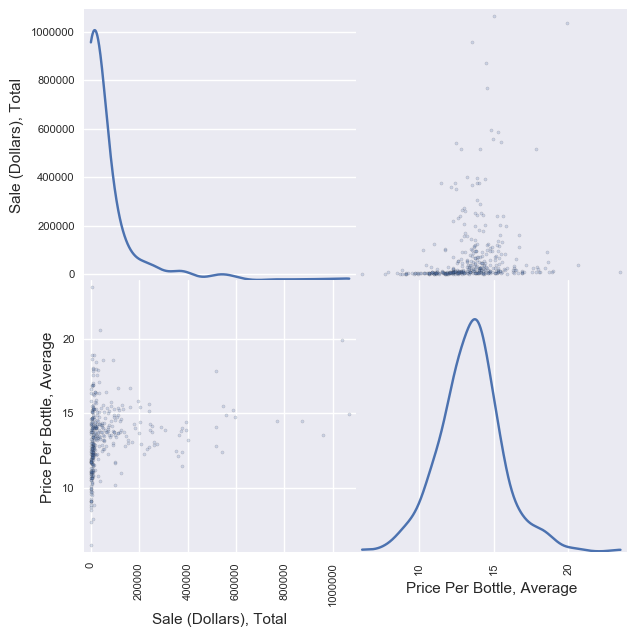

In [23]:
from pandas.tools.plotting import scatter_matrix
a=scatter_matrix(zip_code_sales[['Sale (Dollars), Total','Price Per Bottle, Average']],
                 alpha=0.2, figsize=(7, 7), diagonal='kde')

### Solution Statement

Since this is a supervised machine learning task, with a continuous/quantitative outcome or target (here, that target is total sales dollars), we will be using a linear regression model, OLS. We will also use a k-fold cross validation (10-fold) for the dual purposes of selecting an optimal cost function and for getting a sense of how well our models would perform against unseen, future data.

Based on our visual exploration of the data, given the average price per bottle and the average price per liter, as well as the average volume sold in liters and the total volume sold in liters, we attempt to predict total sales.

### Metric

To gauge how well our models are performing, we will use a common metric for a supervised learning regression, the R^2 score. The R^2 score will tell us how much of the variance between our variables (or features of interest), and our target, that we have explained.

### Benchmark

Our benchmark will be an R^2 score of .70, considering the inherently limited nature of our dataset. In Earth English, we strive to explain at least 70% of the variance between our predictors and our target (total sales).

In [24]:
# import necessary tools from sklearn, patsy, statsmodels, and metrics (specifically, R^2)

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
import patsy
import statsmodels.api as sm
from sklearn.metrics import r2_score

/Users/subbee/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
# Rename columns for use in our modeling
zip_code_sales_for_modeling = zip_code_sales
zip_code_sales_for_modeling.rename(columns={'Sale (Dollars), Total' : 'Sale_Dollars_Total',
                      'Price Per Bottle, Average' : 'Price_Per_Bottle_Average',
                      'Price Per Liter, Average' : 'Price_Per_Liter_Average',
                      'Volume Sold (Liters), Average' : 'Volume_Sold_Liters_Average',
                      'Volume Sold (Liters), Total' : 'Volume_Sold_Liters_Total'
                     }, inplace=True)


In [26]:
# We first need to normalize our features of interest. Based on our visual exploration of
# the data, we have selected the average price per bottle, the average price per liter,
# the average volume sold in liters, and the total volume sold in liters
features = ['Sale_Dollars_Total','Price_Per_Bottle_Average',
              'Price_Per_Liter_Average', 'Volume_Sold_Liters_Average',
              'Volume_Sold_Liters_Total']
zip_code_sales_for_modeling[features] = StandardScaler().fit_transform(
    zip_code_sales_for_modeling[features])

In [27]:
# Run our models using statsmodels.api. We will evaluate our models by our
# R-Squared Score (r2_score)

kf = KFold(len(zip_code_sales_for_modeling), n_folds=10, shuffle=True, random_state=43)

models = ['Sale_Dollars_Total ~ Price_Per_Liter_Average + Volume_Sold_Liters_Average',
         'Sale_Dollars_Total ~ I(Price_Per_Bottle_Average**2)',
         'Sale_Dollars_Total ~ Price_Per_Liter_Average',
         'Sale_Dollars_Total ~ Price_Per_Bottle_Average + Price_Per_Liter_Average', 
         'Sale_Dollars_Total ~ Price_Per_Bottle_Average*Price_Per_Liter_Average',
         'Sale_Dollars_Total ~ Volume_Sold_Liters_Total']

for mm in models:
    outof_sample = []
    in_sample = []
    for train_index, test_index in kf:
        train_df = zip_code_sales.iloc[train_index]
        y_train, X_train = patsy.dmatrices(mm, data=train_df, return_type='dataframe')
        model = sm.OLS(y_train, X_train).fit()
        in_sample.append( r2_score( model.predict(X_train),y_train) )
        test_df = zip_code_sales.iloc[test_index]
        y_test, X_test = patsy.dmatrices(mm, data=test_df, return_type='dataframe')
        outof_sample.append(r2_score(model.predict(X_test),y_test))
    print '------------------'
    print mm
    print 'R^2 outof_sample',np.mean(outof_sample),'R^2 in sample', np.mean(in_sample)
    print '------------------'

------------------
Sale_Dollars_Total ~ Price_Per_Liter_Average + Volume_Sold_Liters_Average
R^2 outof_sample -4.58701517827 R^2 in sample -3.36118357685
------------------
------------------
Sale_Dollars_Total ~ I(Price_Per_Bottle_Average**2)
R^2 outof_sample -1883.48768633 R^2 in sample -1122.10188198
------------------
------------------
Sale_Dollars_Total ~ Price_Per_Liter_Average
R^2 outof_sample -10.2553577646 R^2 in sample -6.44541125037
------------------
------------------
Sale_Dollars_Total ~ Price_Per_Bottle_Average + Price_Per_Liter_Average
R^2 outof_sample -10.2653937147 R^2 in sample -6.40477809857
------------------
------------------
Sale_Dollars_Total ~ Price_Per_Bottle_Average*Price_Per_Liter_Average
R^2 outof_sample -10.3507680527 R^2 in sample -6.15428572967
------------------
------------------
Sale_Dollars_Total ~ Volume_Sold_Liters_Total
R^2 outof_sample 0.986846877904 R^2 in sample 0.98896896488
------------------


### Results - Discussion

As you can clearly see, our models did not perform well, as all of our R^2 scores were negative (with the exception of our last model, but we'll come back to that model in a bit). A negative R^2 score means that the fit of our models (which are lines fitted to the data points) performed worse than merely fitting a straight horizontal line through our data. In other words, when predicting total sales, we would have done better guessing a horizontal line than using all but one (the last model) of our models.

As for our last model, which has an incredible R^2 score of .98 (by using total volume sold, in liters), this is a no-brainer, a pointless model for predicting total sales. It goes without saying that our total sales will naturally increase as a function of volume sold: the more liters we sell, the more money we make.

As such, this last model was included to highlight the limitations of our data, as it exists now. Our numeric dataset features do not allow for any meaningful prediction of total sales, as they are either: 1) non-illuminating derivatives of our other features (e.g. average volume sold is derived from total volume sold) that aren't well correlated with total sales, or 2) as mentioned before, obviously related to total sales, such as total volume sold in liters.

### Conclusion

Perhaps if we combined our data with more data, such as demographic data (with median income information), or more city data (e.g. number of universities/colleges in certain areas), we could come up with a better predictive model for total sales.

Having said all this, the data we currently have does serve our purposes very well.

Though our models did not reach our benchmark, we are not in a bad place. Actually, if we focus on our primary, final objective, which was to discover in which areas to open the alcohol establishment, we should be very excited. In preparing, grouping, exploring, and organizing our data, we discovered which areas of Iowa, by zip code, (and in fact, even by city) perform the best. We discovered which alcohol types sell the most. Therefore, we have clear recommendations on:

### WHERE to set up shop:

In [28]:
# The best performing cities, broken down by zip code
zip_code_and_city_sales.sort_values(ascending=False, by='Sale (Dollars), Total').head(10)

Volume Sold (Liters), Total  Sale (Dollars), Total  \
City            Zip Code                                                       
DES MOINES      50320                        66367.76             1068200.95   
                50314                        58853.62             1038267.17   
CEDAR RAPIDS    52402                        68951.54              959470.60   
IOWA CITY       52240                        55230.10              873107.23   
AMES            50010                        52302.32              767805.14   
DAVENPORT       52807                        39654.35              596547.82   
BETTENDORF      52722                        33848.33              557785.69   
COUNCIL BLUFFS  51501                        35824.44              543081.75   
WEST DES MOINES 50266                        31252.45              541901.76   
CORALVILLE      52241                        29669.21              516438.37   

                          Volume Sold (Liters), Average  \
City            Zip Code                                  
DES MOINES      50320                         11.137151   
                50314                         12.484526   
CEDAR RAPIDS    52402                          9.643974   
IOWA CITY       52240                          8.297625   
AMES            50010                         10.385253   
DAVENPORT       52807                         13.664293   
BETTENDORF      52722                          8.940903   
COUNCIL BLUFFS  51501                          9.674970   
WEST DES MOINES 50266                         15.540649   
CORALVILLE      52241                         17.733136   

                          Sale (Dollars), Average  Price Per Liter, Average  \
City            Zip Code                                                      
DES MOINES      50320                  162.223554                 18.890828   
                50314                  291.983194                 27.203608   
CEDAR RAPIDS    52402                  135.104232                 18.328176   
IOWA CITY       52240                  128.413474                 19.002688   
AMES            50010                  143.129883                 17.778504   
DAVENPORT       52807                  207.861734                 18.754750   
BETTENDORF      52722                  133.225362                 17.773006   
COUNCIL BLUFFS  51501                  141.275695                 17.230999   
WEST DES MOINES 50266                  270.046307                 19.051361   
CORALVILLE      52241                  341.472856                 20.653580   

                          Margin, Total  Price Per Bottle, Average  
City            Zip Code                                            
DES MOINES      50320         356316.11                  14.987421  
                50314         346409.55                  19.909894  
CEDAR RAPIDS    52402         320775.79                  13.524006  
IOWA CITY       52240         291639.57                  14.486304  
AMES            50010         256762.94                  14.516940  
DAVENPORT       52807         199253.77                  14.785964  
BETTENDORF      52722         186241.76                  14.924543  
COUNCIL BLUFFS  51501         181380.76                  12.447553  
WEST DES MOINES 50266         181449.95                  15.675427  
CORALVILLE      52241         172420.26                  17.827809

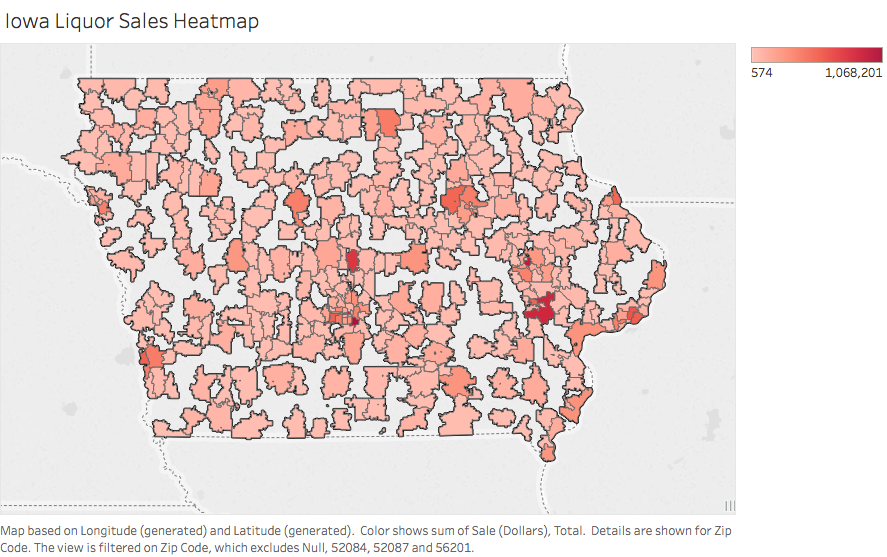

In [29]:
# Heatmap of entire state of Iowa
from IPython.display import Image
Image("Iowa_Liquor_Sales_Heatmap.png")

### WHAT kind of alcohol to sell:

In [30]:
# Bar Chart using Bokeh

df_sales_by_alcohol_bar = df.groupby(by=['Alcohol Type'], as_index=False).agg(
                  {"Sale (Dollars)": np.sum}).round(2)
df_sales_by_alcohol_bar.head()

from bokeh.charts import Bar, show
from bokeh.io import output_notebook
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
p = Bar(df_sales_by_alcohol_bar, 'Alcohol Type', values='Sale (Dollars)', title="Total Sales by Alcohol Type")

show(p)

Loading BokehJS ...

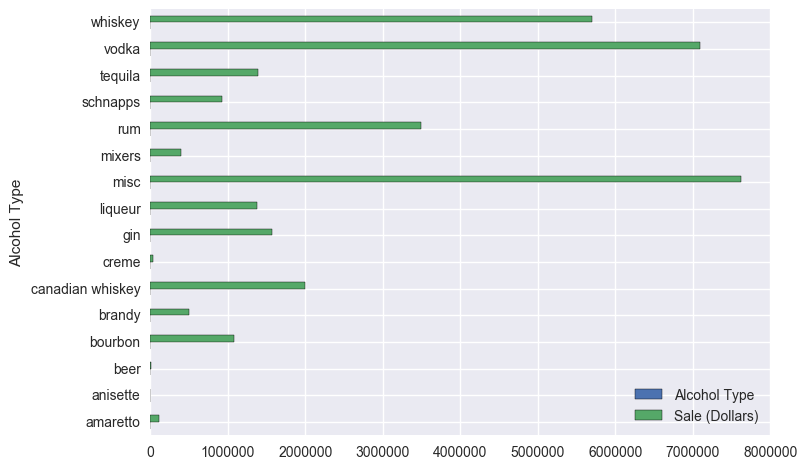

In [31]:
# Or, we can look at the same info as a horizontal bar chart, as we did before
df_sales_by_alcohol_refined.plot.barh()

### And finally, and more powerfully, which alcohol to sell in what city:

In [32]:
df_zip_code_city_alcohol_type = pd.DataFrame(data=df, columns=['Alcohol Type','Sale (Dollars)',
                                                              'Zip Code', 'City'])
df_zip_code_city_alcohol_type.groupby(by=['Zip Code', 'City', 'Alcohol Type']).agg(
                                                                        {'Sale (Dollars)': np.sum})
df_zip_code_city_alcohol_type.sort_values(ascending=False, by='Sale (Dollars)').head(50)

,Alcohol Type,Sale (Dollars),Zip Code,City
40615,whiskey,36392.40,50320,DES MOINES
149769,vodka,32184.00,50266,WEST DES MOINES
28334,vodka,29327.76,52241,CORALVILLE
162687,misc,26054.40,50266,WEST DES MOINES
3335,canadian whiskey,17916.00,50266,WEST DES MOINES
266587,vodka,17820.00,50320,DES MOINES
155218,vodka,17820.00,50320,DES MOINES
19996,vodka,17820.00,50320,DES MOINES
195296,canadian whiskey,17378.52,52641,MOUNT PLEASANT
98858,canadian whiskey,17378.52,51442,DENISON


### Des Moines seems to be a good place to sell alcohol...

In [34]:
# Heatmap of Des Moines, with dots representing the best performing zip codes 50320 and 50314
import os
import folium
from folium.plugins import HeatMap

Des_Moines_Coordinates = (41.6005, -93.6091)

map_of_des_moines = folium.Map(location=Des_Moines_Coordinates, zoom_start=11)

data = np.array([[41.6090, -93.6268]]).tolist()   # Latitude/Longitude of Zip Code 50314
data2 = np.array([[41.5359, -93.5711]]).tolist()  # Latitude/Longitude of Zip Code 50320

HeatMap(data).add_to(map_of_des_moines)
HeatMap(data2).add_to(map_of_des_moines)

map_of_des_moines.save(os.path.join('folium_HeatMap.html'))

map_of_des_moines

### Bottom line: I would recommend a focus on vodka, whiskey, and rum in Des Moines, zip codes 50320 and 50314.

If you were to set up in zip code 50320, I would recommend: vodka, whiskey, and rum. The average bottle price of the items that you stock, which would obviously include other alcohol types (unless you choose to focus on being just a whiskey or vodka specialty shop) should be just shy of $15 (please refer to the table in the section "WHERE to set up shop" for average bottle prices by city and zip code).

If you were to set up in zip code 50314, I would recommend: an emphasis and focus on whiskey. Average bottle price of the items that you stock (again, considering the other items sold in your shop) should be around $20.